# Comparing Networks

In this notebook, we want to compare different network to each other.
We will start of with...

- Untrained Model
- Trained Model
- Trained Model (Exact Unlearning)*$^1$

All these model should serve as comparison point for approximate MU Algorithms, which we want to try out

*$^1$ Exact Unlearning: refers to an complete retraining of the Model, without the samples which we want to unlearn.

In [18]:
import os
import sys

# Add the parent directory to sys.path
sys.path.append(os.path.join('..', 'src'))

import torch
import copy
from PIL import Image
import numpy as np

from mlp_dataclass import MNIST_CostumDataset, TwoLayerPerceptron, ConvNet
from training import main, train_n_models
from helper import load_models_dict

USED_DATASET = "cmnist"
# OUT OF: ["mnist", "cmnist", "fashion_mnist"]

#########################
ALLREADY_TRAINED = True # <--- The Switch
#########################

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

all_data = MNIST_CostumDataset(
    sample_mode="all",
    train= True,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

unlearned_data = MNIST_CostumDataset(
    sample_mode="only_erased",
    train= False,
    test = True,
    dataset_name = USED_DATASET,
    download=True,
)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'


In [19]:
def prepare_sample(path:str):
    """preps sample to pass to model, transforms to tensor, reshape to 784, shaping it as batch"""
    sample = Image.open(path).convert("L")
    sample = torch.Tensor(np.array(sample)).reshape(784)
    
    return sample.unsqueeze(0)

def show_sample(sample:torch.Tensor):
    """Converts the sample to a numpy array and reshapes it to a 28x28 image"""
    sample = sample.reshape(28, 28)
    sample = sample.numpy()
    sample = Image.fromarray(sample)
    return sample

____

### Untrained Model

We want to include an untrained model as a pour reference point.

Later, we will compare the differently trained (and untrained) models on different metrics. We are thinking, that the **untrained model should always be the furthest neighbor** and see if thats true. Also out of pur curiosity, how do the models compare according to the found metrics to the untrained model.

It could be interesting to see, if the unlearned models tend to be more similar to the "Exact MU Model" or to the "Untrained Model"

The "Trained Model"´s and "Exact Model"´s starting point is the "Untrained Model". That means all models can be traced back to it.

In [20]:
from training import save_model

if not ALLREADY_TRAINED:
    untrained_model = TwoLayerPerceptron() if USED_DATASET in ["mnist", "fashion_mnist"] else ConvNet()
    # save it first
    save_model(untrained_model, name="showcase_untrained", path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained", logs=False)

    untrained_ms = {v: TwoLayerPerceptron() for v in range(30)} if USED_DATASET in ["mnist", "fashion_mnist"] else {v: ConvNet() for v in range(30)}

    for i, model in untrained_ms.items():
        save_model(model=model, name=i, path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        untrained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        untrained_showcase_all = ConvNet()
    name = str(untrained_showcase_all)
    untrained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}{name}_showcase_untrained", map_location=DEVICE,
            weights_only=True
            )
        )
    untrained_ms = load_models_dict(f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}untrained{os.sep}ensemble")

___

### Trained Model

This model will be the starting point for all MU algorithms. The more it is important that it does not change throughout the experiments, otherwise we need to run everything again.

Notes Regarding the Dataloader: We included Up-/Downsampling. There is a counter in the Dataset class, which controls, which class is next to provide a sample. From the available pool a sample will be chosen at random.

Reason: The amount of available samples should not influence the performance of the model on certain classes.

Regarding the samples for the class "7": There are more samples of sevens without a middle line than ones with.

Ratio: 
- 6268 (train: 5385, test: 883) 7
- 1025 (train: 880,  test: 145) 7e

Should there be concerns regarding that the bigger part of the sevens (without middle line) will be unlearning?

In [21]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_all = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="all",
        balanced=True,
        dataset_name=USED_DATASET,
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_all= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_all = ConvNet()
    name = str(trained_showcase_all)
    trained_showcase_all.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [22]:
if not ALLREADY_TRAINED:
    trained_ms = train_n_models(
        sampling_mode="all",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    trained_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}all{os.sep}test_ensemble")

___

### Exact Unlearned Model

This model has the same training conditions as the "Trained Model", with the only difference being, that it had no sevens __with no middle line__

In [23]:
# Train a single model first
if not ALLREADY_TRAINED:
    trained_showcase_except = main(
        new_name="trained_showcase",
        model=None,
        sampling_mode="except_erased",
        balanced=True,
        dataset_name=USED_DATASET,
        include_val=True,
        logs=True,
    )
else:
    if USED_DATASET in ["mnist", "fashion_mnist"]:
        trained_showcase_except= TwoLayerPerceptron()
    if USED_DATASET in ["cmnist"]:
        trained_showcase_except = ConvNet()
    name = str(trained_showcase_except)
    trained_showcase_except.load_state_dict(
        torch.load(
            f=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}{name}_b_trained_showcase", map_location=DEVICE,
            weights_only=True
            )
        )

In [24]:
if not ALLREADY_TRAINED:
    exact_ms = train_n_models(
        sampling_mode="except_erased",
        dataset_name=USED_DATASET,
        logs=False,
        test_ensemble=True,
    )
else:
    exact_ms = load_models_dict(path=f"..{os.sep}data{os.sep}models{os.sep}{USED_DATASET}{os.sep}except_erased{os.sep}test_ensemble")

___

## Metrics

### L2 Norm

Compare how the different models are from each other using the L2 Norm, comparing every parameter with each other

In [25]:
from metrics import model_l2_norm_difference, calc_mutlimodel_metric_average

We can luckily cut down on some calculations, since the **L2-Norm** is symmetrical

#### Unlearn to ...

In [26]:
# ...trained model
a11 = calc_mutlimodel_metric_average(untrained_ms, trained_ms, metric="l2_norm")
a11

36.37851738979419

In [27]:
# ...exact model
a12 = calc_mutlimodel_metric_average(untrained_ms, exact_ms, metric="l2_norm")
a12

36.80754758268595

#### Trained to ...

In [28]:
# ...untrained model
a21 = calc_mutlimodel_metric_average(trained_ms, exact_ms, metric="l2_norm")
a21

38.481178574760754

In [29]:
calc_mutlimodel_metric_average(modeltype1=trained_ms, modeltype2=trained_ms, metric="l2_norm")

0.0

#### Exact to ...

In [30]:
# see above

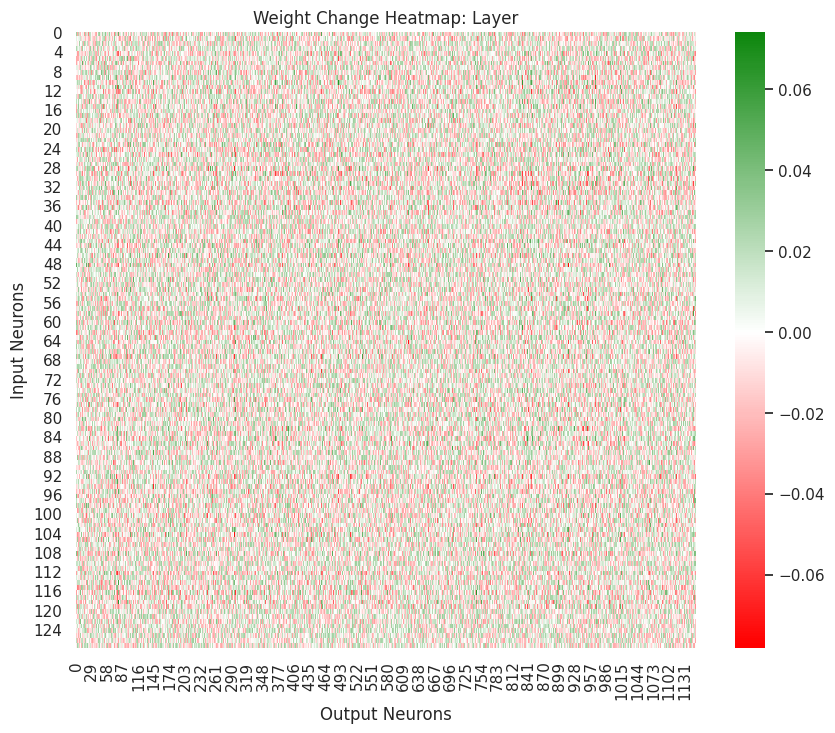

In [31]:
from visualize import visualize_weight_change

visualize_weight_change(weights_before=trained_ms[0].fc1.weight, weights_after=torch.zeros_like(exact_ms[0].fc1.weight))

### Layer-wise Comparison

In [32]:
from metrics import model_layer_wise_difference
lw_dist = {}
for t, mu in zip(trained_ms.values(), exact_ms.values()):
    new = model_layer_wise_difference(t, mu)
    if len(lw_dist) == 0:
        for name in new.keys():
            lw_dist[name] = []
    for name in new.keys():
        lw_dist[name].append(new[name])
for key in lw_dist.keys():
    lw_dist[key] = sum(lw_dist[key])/len(lw_dist[key])
lw_dist

{'conv1.weight': 119.24232177734375,
 'conv1.bias': 4.0703351656595865,
 'conv2.weight': 866.3003865559896,
 'conv2.bias': 2.7464924097061156,
 'conv3.weight': 2309.0764404296874,
 'conv3.bias': 3.691697692871094,
 'fc1.weight': 3144.1625244140623,
 'fc1.bias': 2.5666009028752645,
 'fc2.weight': 83.7479970296224,
 'fc2.bias': 0.5667379091183344}

### KL-Divergence

Used to compare the difference between distribution, but may also be used to compare models by their predicted target distributions.

In [33]:
from metrics import kl_divergence_between_models, calc_mutlimodel_metric_average
from torch.utils.data import DataLoader
dataloader = DataLoader(
    dataset=unlearned_data,
    batch_size=8,
    shuffle=False,
)

#### Untrained to...

In [34]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

1.9815896518448353

In [35]:
calc_mutlimodel_metric_average(
    modeltype1=untrained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

2.079443672715977

#### Trained to...

In [36]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

6.063975957324429

In [37]:
calc_mutlimodel_metric_average(
    modeltype1=trained_ms,
    modeltype2=exact_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.10910214014715634

#### Exact to...

In [38]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=untrained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

7.573352430328246

In [39]:
calc_mutlimodel_metric_average(
    modeltype1=exact_ms,
    modeltype2=trained_ms,
    testing_loader=dataloader,
    metric="kl_div",
)

0.15264837079323448

### Accuracy

- $D_{Gesamt}$
- $D_{Erased}$
- $D_{Remain}$
- $D_{Accuracy Per Class}$

In [40]:
from visualize import boxplotting_multimodel_eval

accs = {}

Now, let us see what metrics each model has

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.0969 - Standard Deviation for D_gesamt: 0.0122


Average Accuracy for D_remain: 0.0919 - Standard Deviation for D_remain: 0.0366


Average Accuracy for 0: 0.1353 - Standard Deviation for 0: 0.3056


Average Accuracy for 1: 0.0527 - Standard Deviation for 1: 0.1900


Average Accuracy for 2: 0.1362 - Standard Deviation for 2: 0.3188


Average Accuracy for 3: 0.0876 - Standard Deviation for 3: 0.2318


Average Accuracy for 4: 0.1398 - Standard Deviation for 4: 0.3318


Average Accuracy for 5: 0.0624 - Standard Deviation for 5: 0.1624


Average Accuracy for 6: 0.0588 - Standard Deviation for 6: 0.1940


Average Accuracy for 8: 0.0835 - Standard Deviation for 8: 0.2197


Average Accuracy for 9: 0.0714 - Standard Deviation for 9: 0.2488


Average Accuracy for 7_all: 0.1410 - Standard Deviation for 7_all: 0.3335


Average Accuracy for 7_remain: 0.1389 - Standard Deviation for 7_remain: 0.3292


Average Accuracy for 7_erased: 0.1411 - Standard Deviation for 7_erased: 0.3337
plotting...


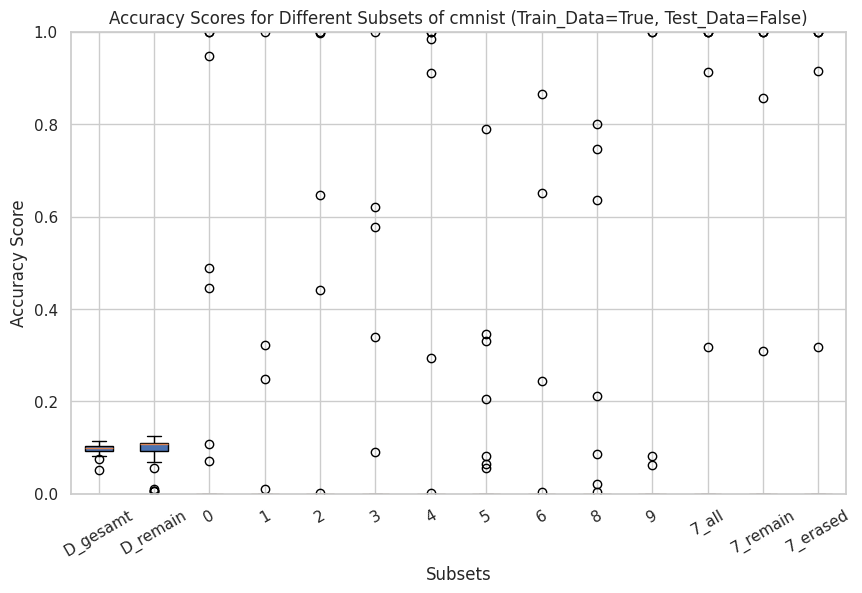

In [41]:
accs["untrained_ms_train"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.0973 - Standard Deviation for D_gesamt: 0.0119


Average Accuracy for D_remain: 0.0925 - Standard Deviation for D_remain: 0.0373


Average Accuracy for 0: 0.1346 - Standard Deviation for 0: 0.3058


Average Accuracy for 1: 0.0546 - Standard Deviation for 1: 0.1929


Average Accuracy for 2: 0.1374 - Standard Deviation for 2: 0.3204


Average Accuracy for 3: 0.0857 - Standard Deviation for 3: 0.2279


Average Accuracy for 4: 0.1424 - Standard Deviation for 4: 0.3339


Average Accuracy for 5: 0.0623 - Standard Deviation for 5: 0.1643


Average Accuracy for 6: 0.0595 - Standard Deviation for 6: 0.1994


Average Accuracy for 8: 0.0839 - Standard Deviation for 8: 0.2250


Average Accuracy for 9: 0.0710 - Standard Deviation for 9: 0.2487


Average Accuracy for 7_all: 0.1413 - Standard Deviation for 7_all: 0.3344


Average Accuracy for 7_remain: 0.1390 - Standard Deviation for 7_remain: 0.3320


Average Accuracy for 7_erased: 0.1414 - Standard Deviation for 7_erased: 0.3345
plotting...


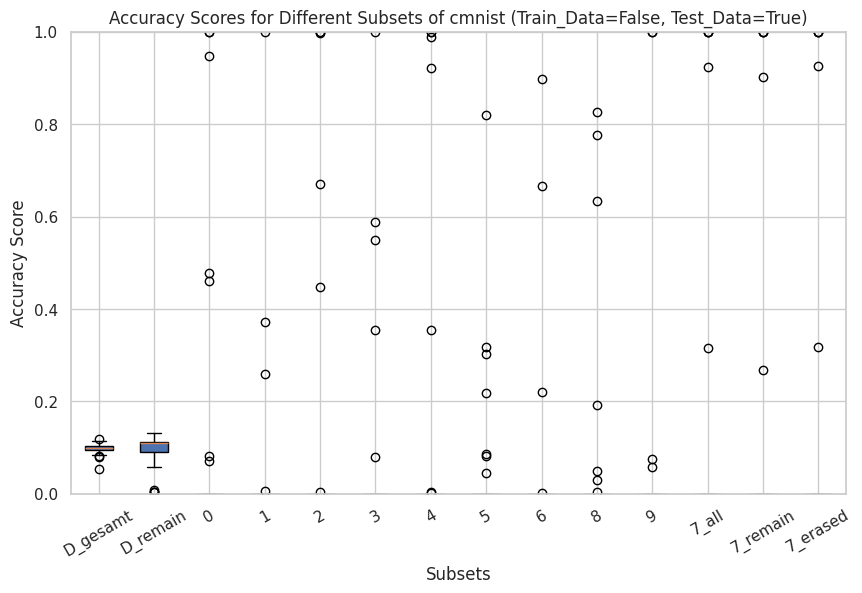

In [42]:
accs["untrained_ms_test"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.9188 - Standard Deviation for D_gesamt: 0.0065


Average Accuracy for D_remain: 0.9220 - Standard Deviation for D_remain: 0.0064


Average Accuracy for 0: 0.9640 - Standard Deviation for 0: 0.0081


Average Accuracy for 1: 0.9606 - Standard Deviation for 1: 0.0052


Average Accuracy for 2: 0.9103 - Standard Deviation for 2: 0.0166


Average Accuracy for 3: 0.8827 - Standard Deviation for 3: 0.0204


Average Accuracy for 4: 0.9230 - Standard Deviation for 4: 0.0153


Average Accuracy for 5: 0.9183 - Standard Deviation for 5: 0.0158


Average Accuracy for 6: 0.9442 - Standard Deviation for 6: 0.0099


Average Accuracy for 8: 0.8894 - Standard Deviation for 8: 0.0223


Average Accuracy for 9: 0.8997 - Standard Deviation for 9: 0.0156


Average Accuracy for 7_all: 0.8921 - Standard Deviation for 7_all: 0.0178


Average Accuracy for 7_remain: 0.9246 - Standard Deviation for 7_remain: 0.0404


Average Accuracy for 7_erased: 0.8906 - Standard Deviation for 7_erased: 0.0171
plotting...


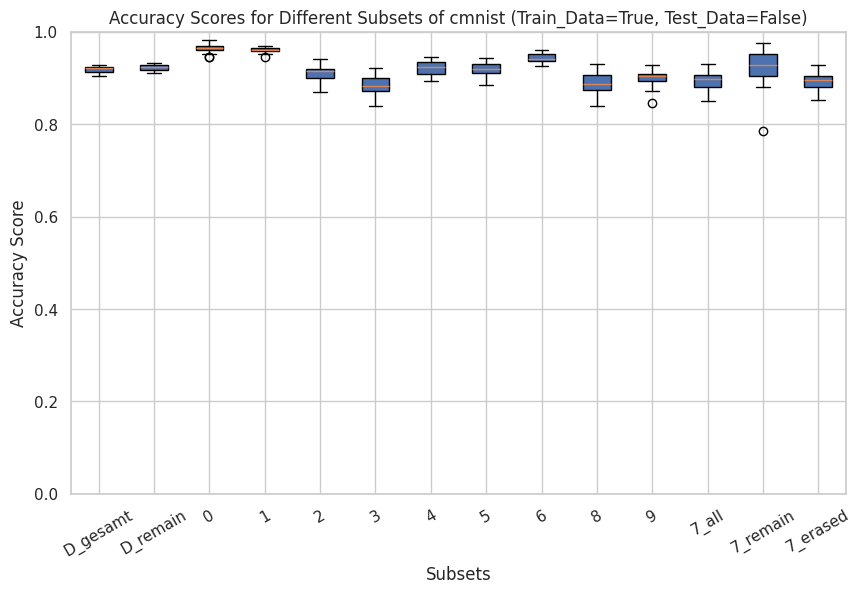

In [43]:
accs["trained_ms_train"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.9176 - Standard Deviation for D_gesamt: 0.0063


Average Accuracy for D_remain: 0.9216 - Standard Deviation for D_remain: 0.0066


Average Accuracy for 0: 0.9734 - Standard Deviation for 0: 0.0070


Average Accuracy for 1: 0.9710 - Standard Deviation for 1: 0.0047


Average Accuracy for 2: 0.9036 - Standard Deviation for 2: 0.0166


Average Accuracy for 3: 0.9021 - Standard Deviation for 3: 0.0188


Average Accuracy for 4: 0.9009 - Standard Deviation for 4: 0.0193


Average Accuracy for 5: 0.9048 - Standard Deviation for 5: 0.0180


Average Accuracy for 6: 0.9389 - Standard Deviation for 6: 0.0132


Average Accuracy for 8: 0.8808 - Standard Deviation for 8: 0.0221


Average Accuracy for 9: 0.9118 - Standard Deviation for 9: 0.0153


Average Accuracy for 7_all: 0.8823 - Standard Deviation for 7_all: 0.0131


Average Accuracy for 7_remain: 0.9260 - Standard Deviation for 7_remain: 0.0099


Average Accuracy for 7_erased: 0.8805 - Standard Deviation for 7_erased: 0.0137
plotting...


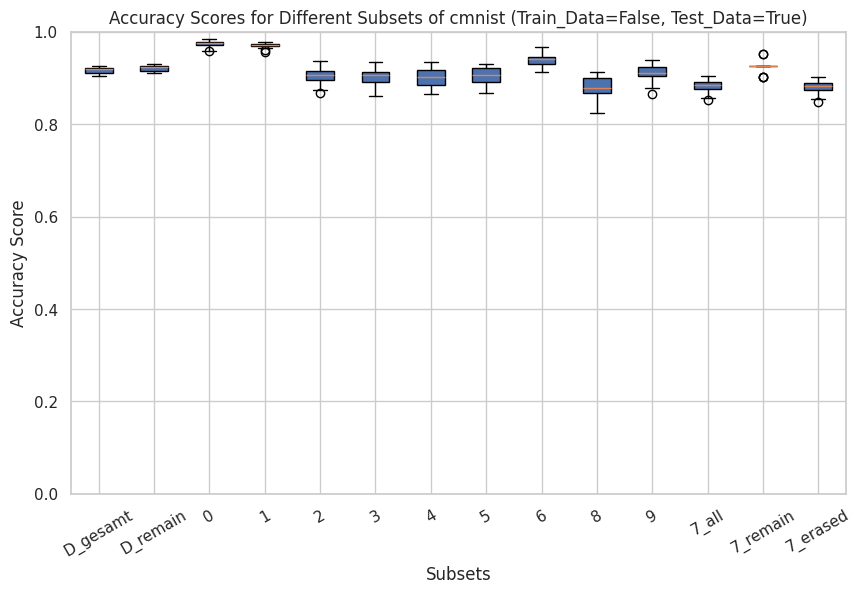

In [44]:
accs["trained_ms_test"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.8886 - Standard Deviation for D_gesamt: 0.0081


Average Accuracy for D_remain: 0.8904 - Standard Deviation for D_remain: 0.0090


Average Accuracy for 0: 0.9502 - Standard Deviation for 0: 0.0245


Average Accuracy for 1: 0.9452 - Standard Deviation for 1: 0.0144


Average Accuracy for 2: 0.8687 - Standard Deviation for 2: 0.0316


Average Accuracy for 3: 0.8362 - Standard Deviation for 3: 0.0365


Average Accuracy for 4: 0.9139 - Standard Deviation for 4: 0.0192


Average Accuracy for 5: 0.8558 - Standard Deviation for 5: 0.0254


Average Accuracy for 6: 0.9262 - Standard Deviation for 6: 0.0211


Average Accuracy for 8: 0.8478 - Standard Deviation for 8: 0.0277


Average Accuracy for 9: 0.8520 - Standard Deviation for 9: 0.0293


Average Accuracy for 7_all: 0.8784 - Standard Deviation for 7_all: 0.0160


Average Accuracy for 7_remain: 0.9913 - Standard Deviation for 7_remain: 0.0130


Average Accuracy for 7_erased: 0.8732 - Standard Deviation for 7_erased: 0.0166
plotting...


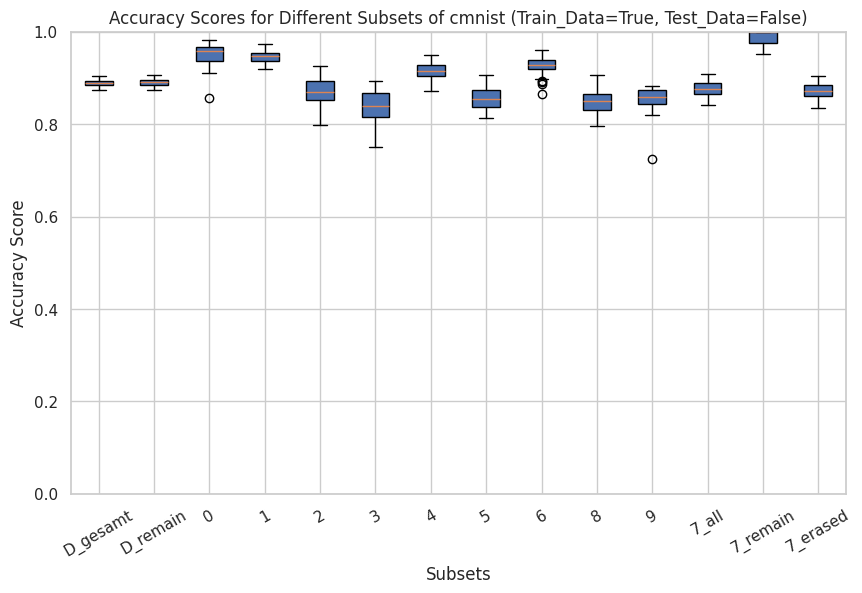

In [45]:
accs["exact_ms_train"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=True, test_split=False, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Accuracy for D_gesamt: 0.8838 - Standard Deviation for D_gesamt: 0.0084


Average Accuracy for D_remain: 0.8861 - Standard Deviation for D_remain: 0.0093


Average Accuracy for 0: 0.9556 - Standard Deviation for 0: 0.0224


Average Accuracy for 1: 0.9526 - Standard Deviation for 1: 0.0161


Average Accuracy for 2: 0.8689 - Standard Deviation for 2: 0.0323


Average Accuracy for 3: 0.8542 - Standard Deviation for 3: 0.0370


Average Accuracy for 4: 0.8888 - Standard Deviation for 4: 0.0233


Average Accuracy for 5: 0.8415 - Standard Deviation for 5: 0.0314


Average Accuracy for 6: 0.9066 - Standard Deviation for 6: 0.0306


Average Accuracy for 8: 0.8413 - Standard Deviation for 8: 0.0243


Average Accuracy for 9: 0.8528 - Standard Deviation for 9: 0.0212


Average Accuracy for 7_all: 0.8650 - Standard Deviation for 7_all: 0.0166


Average Accuracy for 7_remain: 0.9106 - Standard Deviation for 7_remain: 0.0270


Average Accuracy for 7_erased: 0.8632 - Standard Deviation for 7_erased: 0.0167
plotting...


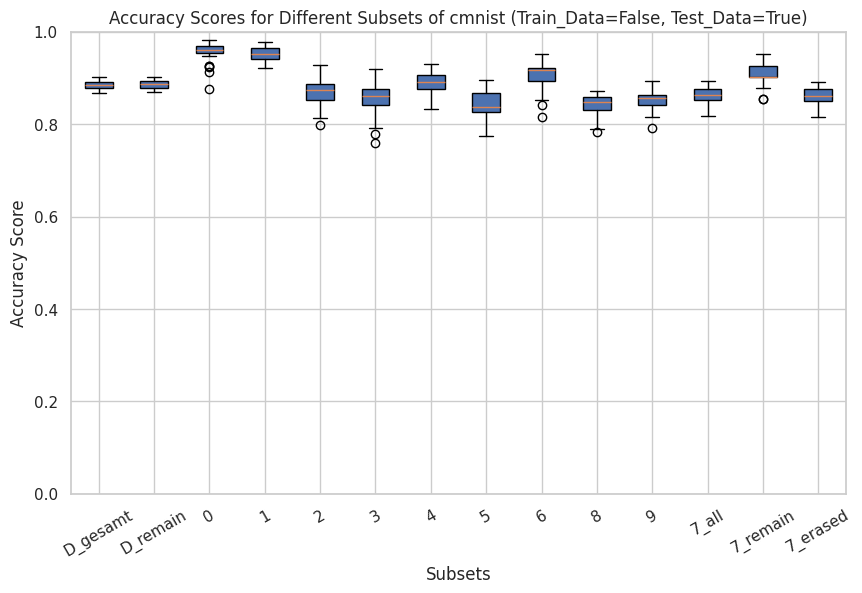

In [46]:
accs["exact_ms_test"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Accuracy", train_split=False, test_split=True, logs=True)

#### Losses

In [47]:
losses = {}

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.2881 - Standard Deviation for D_gesamt: 0.0002


Average Loss for D_remain: 0.2882 - Standard Deviation for D_remain: 0.0008


Average Loss for 0: 0.2893 - Standard Deviation for 0: 0.0069


Average Loss for 1: 0.2879 - Standard Deviation for 1: 0.0057


Average Loss for 2: 0.2894 - Standard Deviation for 2: 0.0069


Average Loss for 3: 0.2879 - Standard Deviation for 3: 0.0059


Average Loss for 4: 0.2898 - Standard Deviation for 4: 0.0073


Average Loss for 5: 0.2904 - Standard Deviation for 5: 0.0070


Average Loss for 6: 0.2884 - Standard Deviation for 6: 0.0062


Average Loss for 8: 0.2900 - Standard Deviation for 8: 0.0063


Average Loss for 9: 0.2893 - Standard Deviation for 9: 0.0055


Average Loss for 7_all: 0.2898 - Standard Deviation for 7_all: 0.0077


Average Loss for 7_remain: 0.3297 - Standard Deviation for 7_remain: 0.0088


Average Loss for 7_erased: 0.2905 - Standard Deviation for 7_erased: 0.0078
plotting...


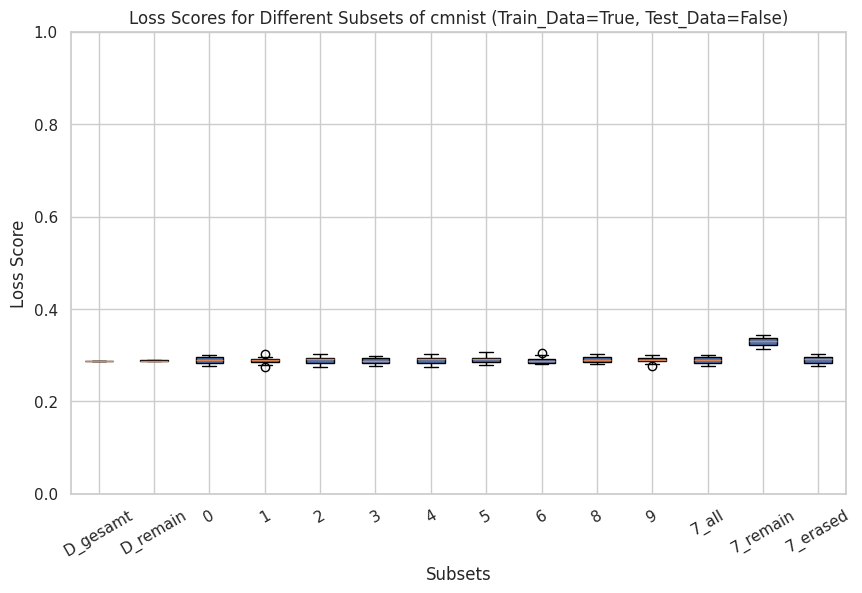

In [48]:
losses["untrained_ms_train"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.2880 - Standard Deviation for D_gesamt: 0.0001


Average Loss for D_remain: 0.2880 - Standard Deviation for D_remain: 0.0008


Average Loss for 0: 0.2892 - Standard Deviation for 0: 0.0069


Average Loss for 1: 0.2881 - Standard Deviation for 1: 0.0057


Average Loss for 2: 0.2874 - Standard Deviation for 2: 0.0069


Average Loss for 3: 0.2887 - Standard Deviation for 3: 0.0059


Average Loss for 4: 0.2887 - Standard Deviation for 4: 0.0073


Average Loss for 5: 0.2902 - Standard Deviation for 5: 0.0070


Average Loss for 6: 0.2880 - Standard Deviation for 6: 0.0062


Average Loss for 8: 0.2889 - Standard Deviation for 8: 0.0063


Average Loss for 9: 0.2903 - Standard Deviation for 9: 0.0055


Average Loss for 7_all: 0.2897 - Standard Deviation for 7_all: 0.0077


Average Loss for 7_remain: 0.3378 - Standard Deviation for 7_remain: 0.0090


Average Loss for 7_erased: 0.2900 - Standard Deviation for 7_erased: 0.0078
plotting...


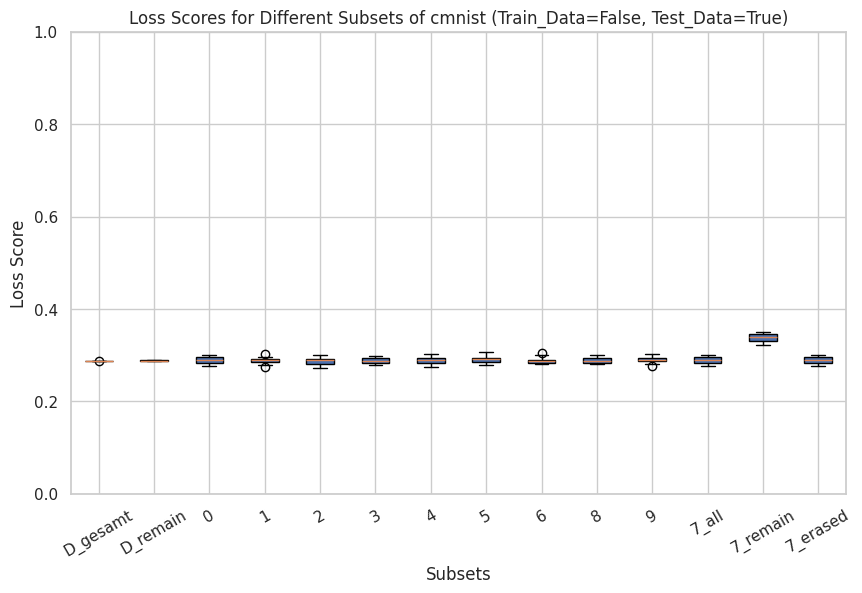

In [49]:
losses["untrained_ms_test"] = boxplotting_multimodel_eval(untrained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.0341 - Standard Deviation for D_gesamt: 0.0024


Average Loss for D_remain: 0.0337 - Standard Deviation for D_remain: 0.0024


Average Loss for 0: 0.0182 - Standard Deviation for 0: 0.0033


Average Loss for 1: 0.0226 - Standard Deviation for 1: 0.0024


Average Loss for 2: 0.0386 - Standard Deviation for 2: 0.0066


Average Loss for 3: 0.0445 - Standard Deviation for 3: 0.0071


Average Loss for 4: 0.0304 - Standard Deviation for 4: 0.0044


Average Loss for 5: 0.0321 - Standard Deviation for 5: 0.0049


Average Loss for 6: 0.0216 - Standard Deviation for 6: 0.0032


Average Loss for 8: 0.0479 - Standard Deviation for 8: 0.0078


Average Loss for 9: 0.0513 - Standard Deviation for 9: 0.0068


Average Loss for 7_all: 0.0379 - Standard Deviation for 7_all: 0.0046


Average Loss for 7_remain: 0.0318 - Standard Deviation for 7_remain: 0.0054


Average Loss for 7_erased: 0.0394 - Standard Deviation for 7_erased: 0.0046
plotting...


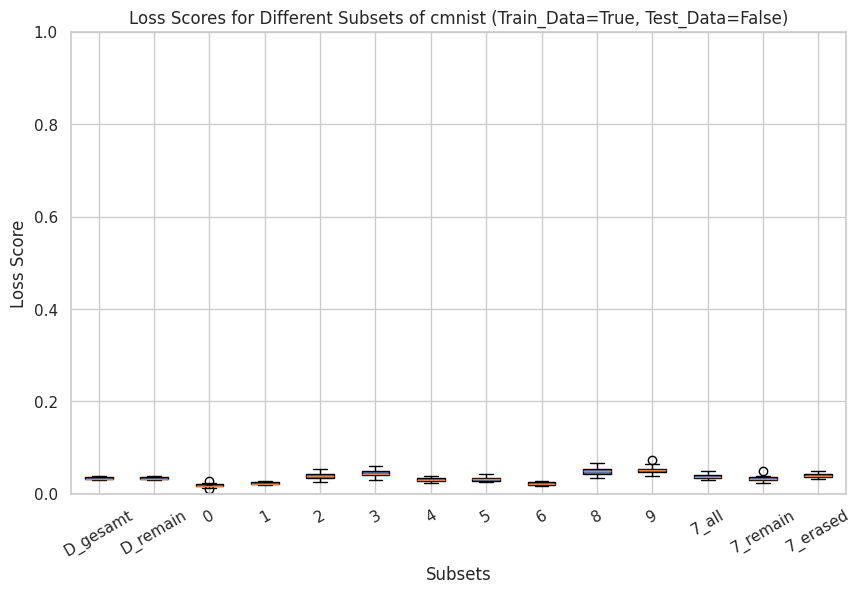

In [50]:
losses["trained_ms_train"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.0349 - Standard Deviation for D_gesamt: 0.0025


Average Loss for D_remain: 0.0340 - Standard Deviation for D_remain: 0.0026


Average Loss for 0: 0.0142 - Standard Deviation for 0: 0.0026


Average Loss for 1: 0.0163 - Standard Deviation for 1: 0.0022


Average Loss for 2: 0.0390 - Standard Deviation for 2: 0.0072


Average Loss for 3: 0.0392 - Standard Deviation for 3: 0.0068


Average Loss for 4: 0.0371 - Standard Deviation for 4: 0.0053


Average Loss for 5: 0.0357 - Standard Deviation for 5: 0.0056


Average Loss for 6: 0.0257 - Standard Deviation for 6: 0.0040


Average Loss for 8: 0.0514 - Standard Deviation for 8: 0.0083


Average Loss for 9: 0.0502 - Standard Deviation for 9: 0.0064


Average Loss for 7_all: 0.0435 - Standard Deviation for 7_all: 0.0047


Average Loss for 7_remain: 0.0420 - Standard Deviation for 7_remain: 0.0043


Average Loss for 7_erased: 0.0435 - Standard Deviation for 7_erased: 0.0048
plotting...


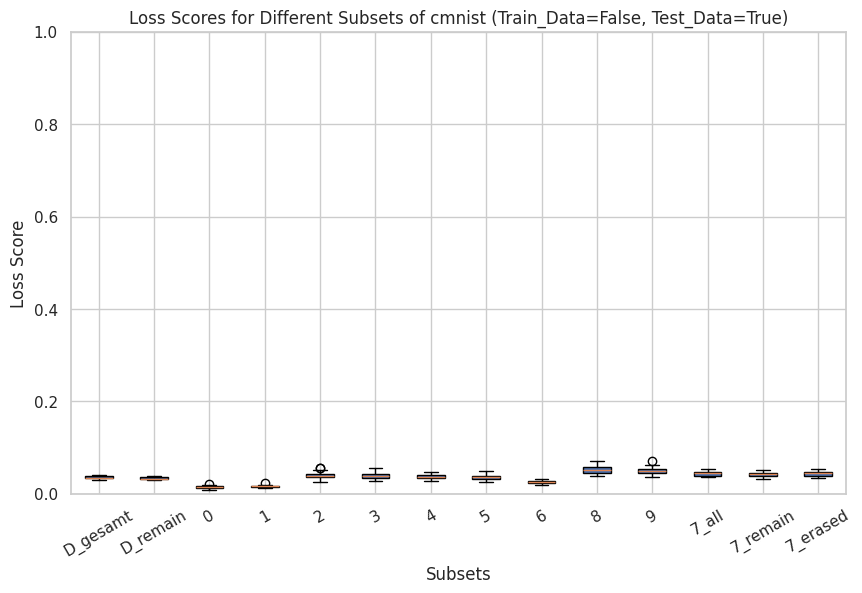

In [51]:
losses["trained_ms_test"] = boxplotting_multimodel_eval(trained_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.0495 - Standard Deviation for D_gesamt: 0.0042


Average Loss for D_remain: 0.0493 - Standard Deviation for D_remain: 0.0047


Average Loss for 0: 0.0243 - Standard Deviation for 0: 0.0138


Average Loss for 1: 0.0376 - Standard Deviation for 1: 0.0123


Average Loss for 2: 0.0655 - Standard Deviation for 2: 0.0186


Average Loss for 3: 0.0661 - Standard Deviation for 3: 0.0175


Average Loss for 4: 0.0332 - Standard Deviation for 4: 0.0076


Average Loss for 5: 0.0591 - Standard Deviation for 5: 0.0136


Average Loss for 6: 0.0356 - Standard Deviation for 6: 0.0134


Average Loss for 8: 0.0604 - Standard Deviation for 8: 0.0122


Average Loss for 9: 0.0683 - Standard Deviation for 9: 0.0148


Average Loss for 7_all: 0.0499 - Standard Deviation for 7_all: 0.0058


Average Loss for 7_remain: 0.0167 - Standard Deviation for 7_remain: 0.0051


Average Loss for 7_erased: 0.0521 - Standard Deviation for 7_erased: 0.0061
plotting...


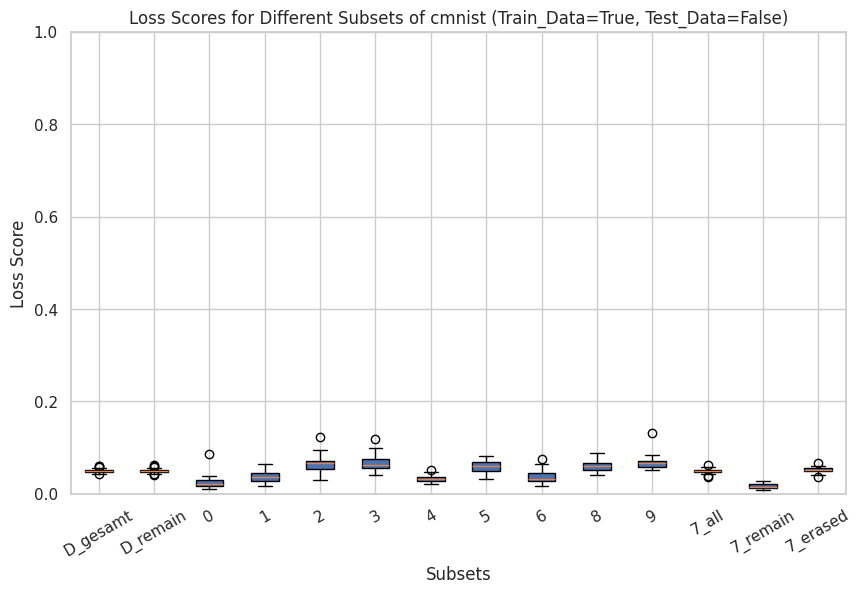

In [52]:
losses["exact_ms_train"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=True, test_split=False, logs=True)

An error occurred: Cmd('git') failed due to: exit code(128)
  cmdline: git clone -v -- https://github.com/jayaneetha/colorized-MNIST.git ../data/cmnist_repo
  stderr: 'fatal: destination path '../data/cmnist_repo' already exists and is not an empty directory.
'
Starts evaluation for 'cmnist'...


Average Loss for D_gesamt: 0.0513 - Standard Deviation for D_gesamt: 0.0044


Average Loss for D_remain: 0.0496 - Standard Deviation for D_remain: 0.0049


Average Loss for 0: 0.0199 - Standard Deviation for 0: 0.0111


Average Loss for 1: 0.0271 - Standard Deviation for 1: 0.0097


Average Loss for 2: 0.0645 - Standard Deviation for 2: 0.0199


Average Loss for 3: 0.0581 - Standard Deviation for 3: 0.0173


Average Loss for 4: 0.0416 - Standard Deviation for 4: 0.0093


Average Loss for 5: 0.0630 - Standard Deviation for 5: 0.0148


Average Loss for 6: 0.0438 - Standard Deviation for 6: 0.0180


Average Loss for 8: 0.0658 - Standard Deviation for 8: 0.0110


Average Loss for 9: 0.0668 - Standard Deviation for 9: 0.0107


Average Loss for 7_all: 0.0666 - Standard Deviation for 7_all: 0.0075


Average Loss for 7_remain: 0.0631 - Standard Deviation for 7_remain: 0.0086


Average Loss for 7_erased: 0.0668 - Standard Deviation for 7_erased: 0.0076
plotting...


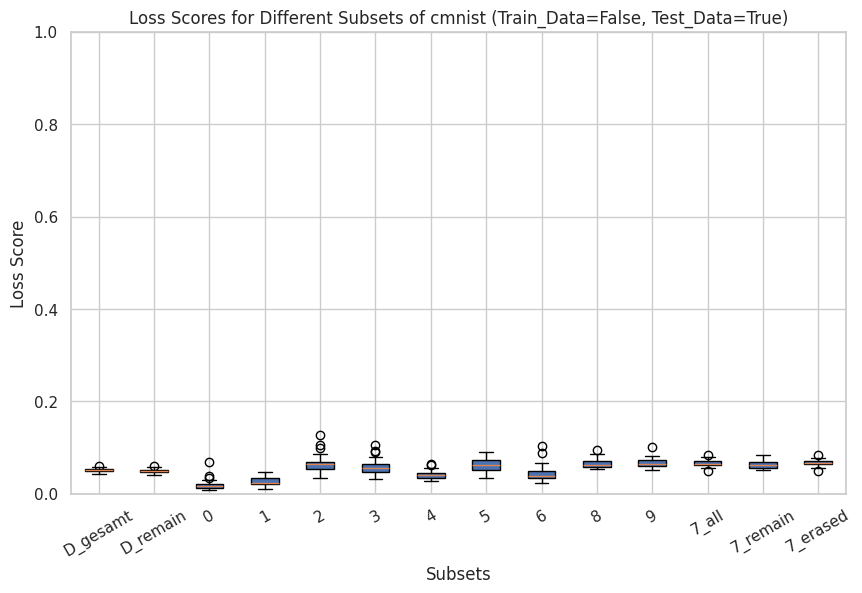

In [53]:
losses["exact_ms_test"] = boxplotting_multimodel_eval(exact_ms, dataset_name=USED_DATASET, evaluation="Loss", train_split=False, test_split=True, logs=True)

___